In [1]:
import pandahouse as ph
import numpy as np
import seaborn as sns

import scipy.stats as stats
from tqdm.notebook import tqdm

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'xxx',
    'user': 'xxx',
    'database': 'xxx'
}

In [3]:
query = """
select
  user_id,
  exp_group,
  countIf(user_id, action = 'like') as likes,
  countIf(user_id, action = 'view') as views,
  likes / views as ctr
from
  {db}.feed_actions
where
  toDate(time) between '2023-01-30'
  and '2023-01-30'
  and exp_group in (2, 3)
group by
  exp_group,
  user_id
"""

df = ph.read_clickhouse(query, connection=connection)

In [4]:
df.head()

,user_id,exp_group,likes,views,ctr
0,27467,3,11,84,0.130952
1,110625,3,11,68,0.161765
2,23232,3,1,15,0.066667
3,115383,3,7,20,0.350000
4,131473,2,8,85,0.094118


In [5]:
# получаем вектор значений CTR для каждой группы
ctr_g2 = df[df['exp_group'] == 2]['ctr'].copy().values
ctr_g3 = df[df['exp_group'] == 3]['ctr'].copy().values

print(ctr_g2.shape, ctr_g3.shape)

(2563,) (2568,)


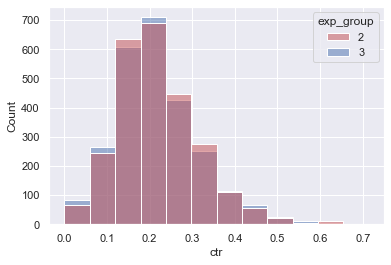

In [6]:
# взглянем на распределения CTR по группам
sns.set_theme(rc={'figure.figsize': (10, 8)})

# посчитаем кол-во интервалов
bins = 1 + int(np.log2(max(len(ctr_g2), len(ctr_g2))))

sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'], 
             bins=bins);

In [9]:
N = 10000
n_users = 500
p_values_list = []

for _ in tqdm(range(N)):
    users_500_from_g2 = np.random.choice(ctr_g2,
                                         size=n_users,
                                         replace=False
                                        )
    
    users_500_from_g3 = np.random.choice(ctr_g3,
                                         size=n_users,
                                         replace=False
                                        )
    
    statistic, p_value = stats.ttest_ind(a=users_500_from_g2, 
                                         b=users_500_from_g3,
                                         equal_var=False)
    p_values_list.append(np.round(p_value, 4))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
p_values_list[:5]

[0.7319, 0.6784, 0.1249, 0.7589, 0.4375]

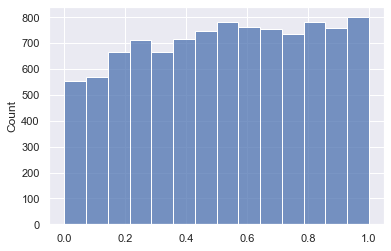

In [13]:
# распределение значений p-values
bins = 1 + int(np.log2(len(p_values_list)))
sns.histplot(data=p_values_list,
             palette=['r'], 
             bins=bins);

In [14]:
p_values_arr = np.array(p_values_list[:])

In [24]:
percent_0_05 = (len(p_values_arr[p_values_arr <= 0.05]) / len(p_values_arr)) * 100

In [26]:
print(f'(p-values < 0.05) = {percent_0_05}%')

(p-values < 0.05) = 3.66%


In [31]:
print('''
Вывод: примерно 3.66% сравнений выборок выявили статистическую значимость.
Если мы возьмем значение предела в 5%, то наша система сплитования работает корректно 96,34% случаях.
''')


Вывод: примерно 3.66% сравнений выборок выявили статистическую значимость.
Если мы возьмем значение предела в 5%, то наша система сплитования работает корректно 96,34% случаях.

